# Miniproject: Image Classification

### Description

One of the oldest traditions in deep learning is to first tackle the fun problem of MNIST classification. [The MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://keras.io/examples/) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "Adam", "convolutional neural network", "training and validation data", "overfitting", "regularization", and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data (i.e. training).
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length.

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [475]:
student1 = "Jan Bauer (18-764-571)"
student2 = "Adrien Bertaud (Sciper 324795)"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [476]:
%matplotlib inline

import os

import numpy as np
from numpy.random import normal, choice

import time
import matplotlib.pyplot as plt
import scipy.io

#import tensorflow and keras
import tensorflow as tf
import keras
from keras import backend as K
from keras import Model
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Input
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, History
from keras.preprocessing.image import ImageDataGenerator 

In [477]:
print("Running tensorflow version: {0}".format(tf.__version__))
print("Running keras version: {0}".format(keras.__version__))

Running tensorflow version: 2.4.1
Running keras version: 2.4.3


In [478]:
# Ensure a GPU is on the list
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Plotting

In [479]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    return plot_history_custom(history.history, title)

def plot_history_custom(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history['loss'], label = "train")
    ax1.plot(history['val_loss'], label = "val")
    ax2.plot(history['accuracy'], label = "train")
    ax2.plot(history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_some_samples_custom(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """
    Plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, label_mapping[j], color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, label_mapping[k], color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig




## Exercise 1: Data import and visualization (6 points)

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. 
The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the training converges faster. This is an advantage in situations like here (or generally when prototyping), where we want to try many different things without having to wait too long. 

1. As a warm-up exercise, use the importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the function `plot_some_samples` defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (2 pts)
3. To prepare for training: 1. transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (you can use `utils.to_categorical` function from keras), and 2. reshape (flatten) the input images to input vectors and rescale the input data into the range [0,1]. (2 pts)

*Hint*: Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets. 

**Answer to Question 2** (1 sentence):<br/>
The green digit at the bottom left corresponds to '(label_mapping[j]+1)%10' (*true class label incremented by one and divided modulo 10*) and can be interpreted as the index of the digit with value 1 (all others at 0) for one hot encoding.

### Solution

#### Exercise 1.1
Load the MNIST and Fashion-MNIST dataset.

In [480]:
(x_mnist_train, y_mnist_train), (x_mnist_val, y_mnist_val) = tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_mnist_fash_train, y_mnist_fash_train), (x_mnist_fash_val, y_mnist_fash_val) = tf.keras.datasets.fashion_mnist.load_data()

#### Exercise 1.2
Plot some samples of the two datasets.

MNIST


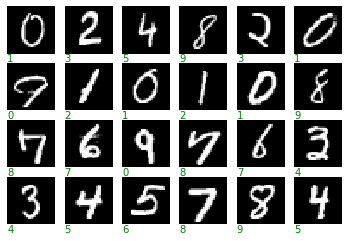

In [481]:
print("MNIST")
plot_some_samples(x_mnist_train, y_mnist_train, ncols=6, nrows=4);

Fashion-MNIST


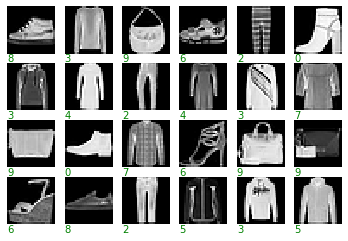

In [482]:
print("Fashion-MNIST")
plot_some_samples(x_mnist_fash_train, y_mnist_fash_train, ncols=6, nrows=4);

#### Exercise 1.3
Prepare for training.

In [483]:
# transform the labels to one hot coding
from keras.utils import to_categorical

# One hot encode the labels
y_mnist_train_1hot = to_categorical(y_mnist_train)
y_mnist_val_1hot = to_categorical(y_mnist_val)

print("MNIST:")
for i in range(5):
    print("train : {0} => {1} \ttest : {2} => {3}".format(y_mnist_train[i], y_mnist_train_1hot[i], y_mnist_val[i], y_mnist_val_1hot[i]))

MNIST:
train : 5 => [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 	test : 7 => [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 2 => [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
train : 4 => [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 	test : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 	test : 4 => [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [484]:
# One hot encode the labels
y_mnist_fash_train_1hot = to_categorical(y_mnist_fash_train)
y_mnist_fash_val_1hot = to_categorical(y_mnist_fash_val)

print("Fashion MNIST:")
for i in range(5):
    print("train : {0} => {1} \ttest : {2} => {3}".format(y_mnist_fash_train[i], y_mnist_fash_train_1hot[i], y_mnist_fash_val[i], y_mnist_fash_val_1hot[i]))

Fashion MNIST:
train : 9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 	test : 9 => [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 2 => [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 3 => [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 	test : 1 => [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
train : 0 => [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 	test : 6 => [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [485]:
# MNIST: rescale the input data into the range [0,1]
max_grey_value = 255.0

print("MNIST")
print("Max value in initial dataset (train/test):", np.max(x_mnist_train), np.max(x_mnist_val))
print("Min value in initial dataset (train/test):", np.min(x_mnist_train), np.min(x_mnist_val))
x_mnist_train = x_mnist_train / max_grey_value  
x_mnist_val = x_mnist_val / max_grey_value 
print("Max value in rescaled dataset (train/test):", np.max(x_mnist_train), np.max(x_mnist_val))
print("Min value in rescaled dataset (train/test):", np.min(x_mnist_train), np.min(x_mnist_val))

MNIST
Max value in initial dataset (train/test): 255 255
Min value in initial dataset (train/test): 0 0
Max value in rescaled dataset (train/test): 1.0 1.0
Min value in rescaled dataset (train/test): 0.0 0.0


In [486]:
# MNIST: rescale the input data into the range [0,1]
print("Fashion-MNIST")
print("Max value in initial dataset (train/test):", np.max(x_mnist_fash_train), np.max(x_mnist_fash_val))
print("Min value in initial dataset (train/test):", np.min(x_mnist_fash_train), np.min(x_mnist_fash_val))
x_mnist_fash_train = x_mnist_fash_train / max_grey_value  
x_mnist_fash_val = x_mnist_fash_val / max_grey_value 
print("Max value in rescaled dataset (train/test):", np.max(x_mnist_fash_train), np.max(x_mnist_fash_val))
print("Min value in rescaled dataset (train/test):", np.min(x_mnist_fash_train), np.min(x_mnist_fash_val))

Fashion-MNIST
Max value in initial dataset (train/test): 255 255
Min value in initial dataset (train/test): 0 0
Max value in rescaled dataset (train/test): 1.0 1.0
Min value in rescaled dataset (train/test): 0.0 0.0


In [487]:
# reshape (flatten) the input images to input vectors
print("MNIST")
original_mnist_train_shape = x_mnist_train.shape
original_mnist_val_shape = x_mnist_val.shape
x_mnist_tr_flat = x_mnist_train.reshape(x_mnist_train.shape[0], x_mnist_train.shape[1]*x_mnist_train.shape[2])
x_mnist_val_flat = x_mnist_val.reshape(x_mnist_val.shape[0], x_mnist_val.shape[1]*x_mnist_val.shape[2])
print("Reshaped training data from {0} to {1}".format(original_mnist_train_shape, x_mnist_tr_flat.shape))
print("Reshaped validation data from {0} to {1}".format(original_mnist_val_shape, x_mnist_val_flat.shape))

MNIST
Reshaped training data from (60000, 28, 28) to (60000, 784)
Reshaped validation data from (10000, 28, 28) to (10000, 784)


In [488]:
print("Fashion-MNIST")
original_train_shape = x_mnist_fash_train.shape
original_val_shape = x_mnist_fash_val.shape
original_val_shape = x_mnist_fash_val.shape
x_fashion_tr_flat = x_mnist_fash_train.reshape(x_mnist_fash_train.shape[0], x_mnist_fash_train.shape[1]*x_mnist_fash_train.shape[2])
x_fashion_val_flat = x_mnist_fash_val.reshape(x_mnist_fash_val.shape[0], x_mnist_fash_val.shape[1]*x_mnist_fash_val.shape[2])
x_fashion_val_flat = x_mnist_fash_val.reshape(x_mnist_fash_val.shape[0], x_mnist_fash_val.shape[1]*x_mnist_fash_val.shape[2])
print("Reshaped training data from {0} to {1}".format(original_train_shape, x_fashion_tr_flat.shape))
print("Reshaped validation data from {0} to {1}".format(original_val_shape, x_fashion_val_flat.shape))
print("Reshaped test data from {0} to {1}".format(original_val_shape, x_fashion_val_flat.shape))

Fashion-MNIST
Reshaped training data from (60000, 28, 28) to (60000, 784)
Reshaped validation data from (10000, 28, 28) to (10000, 784)
Reshaped test data from (10000, 28, 28) to (10000, 784)


In [489]:
# Constants
input_dim_mnist = x_mnist_tr_flat.shape[1]
input_dim_fashion = x_fashion_tr_flat.shape[1]
# Get number of classes
mnist_classes_nb = y_mnist_train_1hot.shape[1]
fashion_classes_nb = y_mnist_fash_train_1hot.shape[1]
print("MMNIST Input Shape {0}; MNIST Number Of Classes {1}".format(input_dim_mnist, mnist_classes_nb))
print("MMNIST Fashion Input Shape {0}; MNIST Fashion Number Of Classes {1}".format(input_dim_fashion, fashion_classes_nb))

MMNIST Input Shape 784; MNIST Number Of Classes 10
MMNIST Fashion Input Shape 784; MNIST Fashion Number Of Classes 10


## Exercise 2: No hidden layer (10 points)

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). Note that in this miniproject there is no real test dataset and what is loaded as a test dataset is used for validation. First, implement 1.-3. for the MNIST dataset.  

1. Implement the model with the following specifications: use the softmax activation for the output layer, use the categorical_crossentropy loss, choose stochastic gradient descent for the optimizer, and add the accuracy metric to the metrics. (5 pts)
2. Train for as many epochs as needed to see no further decrease in the validation loss. (1 pt)
3. Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above. (1 pt)
4. Repeat the above steps for fitting the network to the Fashion-MNIST dataset. (2 pts)
5. Report the best validation accuracy achieved for each one of the datasets. Do you observe overfitting already for this simple model? Answer separetely for the MNIST dataset and Fashion-MNIST dataset. (1 pt) 

*Hint:* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).

**Answer to Question 5** (max 2 sentences):<br/>
*MNIST:*
We don't see overfitting on MNIST with this simple model.

If overfitting, we should see the validation loss stopping to decrease (i.e. increasing). Furthermore, since there is a lot of training data for a models with only 7960 parameters it is unlikely that the model is overfitting.

*Fashion-MNIST:*

Like previoulsy, we don't see overfitting on Fashion-MNIST with this simple model.

Same interpretation than MNIST regarding overfitting, even more Fashion-MNIST has been introduced as beeing "harder".

### Solution

### Useful functions

In [490]:
def get_save_dir():
  """Get directory where models and histories are saved."""
  save_dir = 'save'
  if os.path.isdir(save_dir) is not True:
    os.mkdir(save_dir)
  return save_dir


def get_path_history(exercise_name):
  """Get path of history file."""
  return os.path.join(get_save_dir(), exercise_name + '_history.npy')


def get_path_model(exercise_name):
  """Get path of model file."""
  return os.path.join(get_save_dir(), exercise_name + '_model.keras')


def get_callbacks(early_stop = True, save_model=False, exercise_name='', verbose=0):
  callbacks = []

  if save_model:
    save_callback = ModelCheckpoint(get_path_model(exercise_name), monitor='val_loss', mode='min', save_best_only=True, verbose=verbose)
    callbacks.append(save_callback)

  if early_stop:
    stop_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=verbose, patience=20)
    callbacks.append(stop_callback) 

  return callbacks  


def fit_custom(exercise_name, model, x, y, validation_data=None, epochs=None, callbacks=None, verbose=0):
  """
  Load saved history or launch fit if it does not exist.

  Parameters:
  - exercise_name: String name of the exercise, it is used to store the history and reload it.
  - model: Keras Model from which fit is applied. 
  
  Others inputs are named in the same way that the Keras fit function, and are directly passed to it:
  - x : Vector, matrix, or array of training data
  - y : Vector, matrix, or array of target (label) data
  - validation_data : Data on which to evaluate the loss and any model metrics at the end of each epoch.
  - epochs : Number of epochs to train the model.
  - verbose : Verbosity mode (0 = silent, 1 = progress bar, 2 = one line per epoch)
  - callbacks : List of callbacks to be called during training.
  """
  path_history = get_path_history(exercise_name)

  if not os.path.isfile(path_history):
    print("Begin to train the model {0}.".format(exercise_name))
    fit_output = model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, callbacks=callbacks, verbose=verbose)
    print("Finished training the model {0}.".format(exercise_name))
    history = fit_output.history
    np.save(path_history, history)
  else:
    print("Loading", path_history)
    history = np.load(path_history,allow_pickle='TRUE').item()

  return history


def get_model(input_dim, layers, h, optimizer, lr, dropout = 0, l2 = 0):
    """
    Return a compiled model with:
    - 'input_dim' input dimension 
    - 'layers' hidden layers 
    - 'h' units in each hidden layer
    - 'optimizer' optimizer
    - "lr' learning rate
    - 'dropout' dropout rate
    - 'l2' L2 regularization factor
    """
    # Clear the session to remove all the nodes left over from previous models, free memory and prevent slowdown.
    K.clear_session()

    model = Sequential()
    model.add(Dense(mnist_classes_nb, activation='relu', name="input_layer",  input_shape=(input_dim_mnist,)))

    if(dropout > 0):
      model.add(Dropout(dropout))

    for i in range(layers):
      kernel_regularizer = None

      if(l2>0):
        kernel_regularizer = regularizers.l1_l2(l1=0, l2=l2)

      model.add(Dense(h, activation='relu', kernel_regularizer=kernel_regularizer))

      if(dropout > 0):
        model.add(Dropout(dropout))

    model.add(Dense(mnist_classes_nb, activation='softmax', name="output_layer"))
    model.compile(optimizer=optimizer(lr), loss='categorical_crossentropy', metrics=["accuracy"])
    return model

#### Exercise 2.1
Implement the model.

In [491]:
model=get_model(input_dim=input_dim_mnist, layers=0, h=0, optimizer=SGD, lr=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 10)                7850      
_________________________________________________________________
output_layer (Dense)         (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


#### Exercise 2.2
Train for as many epochs as needed to see no further decrease in the validation loss.

In [492]:
exercise_name='ex_2.2'

history = fit_custom(
    exercise_name=exercise_name,
    model=model, 
    x=x_mnist_tr_flat, 
    y=y_mnist_train_1hot, 
    validation_data=(x_mnist_val_flat, y_mnist_val_1hot), 
    epochs=100,
    callbacks=get_callbacks(early_stop = True, save_model=False, exercise_name=exercise_name),
    verbose=0)

Loading save/ex_2.2_history.npy


#### Exercise 2.3

Plot the learning curves resulting from the fitting procedure (a history object) using the function `plot_history` defined above.

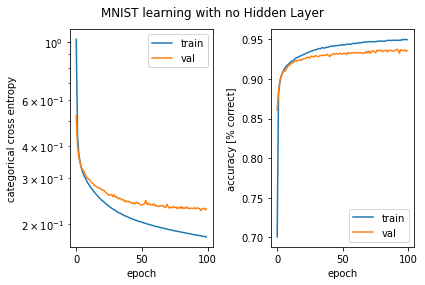

In [493]:
plot_history_custom(history, "MNIST learning with no Hidden Layer");

#### Exercise 2.4

Repeat with the Fashion-MNIST dataset.

In [494]:
model=get_model(input_dim=input_dim_fashion, layers=0, h=0, optimizer=SGD, lr=0.01)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 10)                7850      
_________________________________________________________________
output_layer (Dense)         (None, 10)                110       
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
_________________________________________________________________


In [495]:
exercise_name = 'ex_2.4'
history = fit_custom(
    exercise_name=exercise_name, 
    model=model,
    x=x_fashion_tr_flat, 
    y=y_mnist_fash_train_1hot, 
    validation_data=(x_fashion_val_flat, y_mnist_fash_val_1hot), 
    epochs=100,
    callbacks=get_callbacks(early_stop = True, save_model=False, exercise_name=exercise_name),
    verbose=1)

Loading save/ex_2.4_history.npy


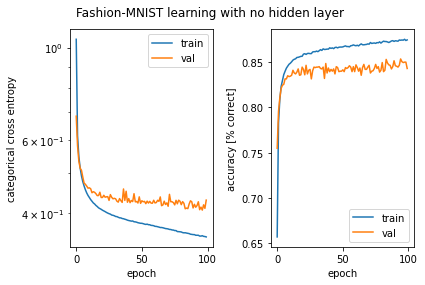

In [496]:
plot_history_custom(history, "Fashion-MNIST learning with no hidden layer ");

## Exercise 3: One hidden layer, different optimizers (10 points)

Train a network with one hidden layer and compare different optimizers for the MNIST dataset.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way. (1 pt)
2. Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate $\eta$ is very large (for ex. $\eta=1$), and very small (for ex. $\eta=0.001$)? Comment on the fluctuations of the learning curve. (2 pts)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate). (1pt)
4. Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (1 pts)
5. Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so? (2 pts)
6. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples`. (1 pt)

Real-world datasets are labeled by some people and sometimes there are mistakes in the labeling. We will corrupt labels of the MNIST dataset artifically, and observe an overfitting to this noisy dataset with Adam. 

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)

**Answer to Question 2** (max 2 sentences): We can see in the diagrams that fluctuations of the learning curve are increasing with the learning rate (for small learning rates {0.01, 0.001} almost no fluctuations in the learning curves can be seen anymore and the shapes are really smooth). This can be explained by the fact that with a small learning rates, the algorithm makes smaller steps, and so weights change less before correcting direction.

**Answer to Question 5** (max 3 sentences): Adam is faster to learn but at the end they perform in the same way (so faster leaning, but similar performances). We can explain it, saying that the networks are the same, but in Adam case the learning rate is adapting. To get models of similar performances, we must stop learning when it begins to overfit (around 5 epochs for Adam).

**Answer to Question 7** (max 2 sentences): In normal and noisy case, there is overfitting. The noisy dataset begins to sooner (after around 5 epochs) and its results are worth.

### Solution

### Useful functions

In [497]:
def train_with_various_lr(exercise_name, model, learning_rates, optimizer):
  """Train with various learning rates."""
  histories = []

  for lr in learning_rates:
    name = exercise_name + '_lr_{0}'.format(lr)
    history = fit_custom(
          exercise_name=name, 
          model=model(lr), 
          x=x_mnist_tr_flat, 
          y=y_mnist_train_1hot, 
          validation_data=(x_mnist_val_flat, y_mnist_val_1hot), 
          epochs=50, 
          callbacks=get_callbacks(early_stop = False, save_model=True, exercise_name=name),
          verbose=0)
      
    optimizer_name = str(optimizer).split(".")[-1].replace('>', '').replace("'", "")

    plot_history_custom(
        history, 
        "MNIST learning with {0} and learning rate {1}".format(optimizer_name,lr));

    histories.append(history)
  return histories

def comparison_plot_custom(history_1, history_2, label1, label2, title):
  """Plot to compare two histories."""
  fig, ax1, ax2 = prepare_standardplot(title, "epochs")
  ax1.plot(history_1['loss'], label=label1 + ' train')
  ax1.plot(history_1['val_loss'], label=label1 + ' val')
  ax1.plot(history_2['loss'], label=label2 + ' train')
  ax1.plot(history_2['val_loss'], label=label2 + ' val')
  ax2.plot(history_1['accuracy'], label=label1 + ' train')
  ax2.plot(history_1['val_accuracy'], label=label1 + ' val')
  ax2.plot(history_2['accuracy'], label=label2 + ' train')
  ax2.plot(history_2['val_accuracy'], label=label2 + ' val')
  finalize_standardplot(fig, ax1, ax2)
  return fig

def noise_labels(y_hot, p):
  """Noise one hot labels according to the fraction 'p'."""
  length = y_hot.shape[0]
  number_of_classes = y_hot.shape[1]

  # Define indices to noise
  indices = np.arange(length)
  noise_number_mnist = int(length*p)
  noisy_indices = choice(indices, noise_number_mnist)

  # Generate noisy labels
  y_1hot_noisy = y_hot.copy()
  for index in noisy_indices:
    class_index = np.floor(np.random.uniform(0,number_of_classes-0.01))
    y_1hot_noisy[index] = to_categorical(class_index, num_classes=mnist_classes_nb)

  return y_1hot_noisy

#### Exercise 3.1

Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/api/models/model/#summary-method) to display your model in a compact way.

In [498]:
def get_model_ex_3_1(learning_rate):
  """Create a model with 1 hidden layer and 128 units, compiled with SGD optimizer."""
  return get_model(input_dim=input_dim_mnist, layers=1, h=128, optimizer=SGD, lr=learning_rate)

get_model_ex_3_1(0.01).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Dense)          (None, 10)                7850      
_________________________________________________________________
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 10,548
Trainable params: 10,548
Non-trainable params: 0
_________________________________________________________________


#### Exercise 3.2

Train the model for at least 50 epochs with different learning rates of stochastic gradient descent (SGD). What happens if the learning rate  𝜂 is very large (for ex.  𝜂=1), and very small (for ex.  𝜂=0.001)? Comment on the fluctuations of the learning curve.

Loading save/ex_3.2_lr_1_history.npy
Loading save/ex_3.2_lr_0.1_history.npy
Loading save/ex_3.2_lr_0.01_history.npy
Begin to train the model ex_3.2_lr_0.001.


KeyboardInterrupt: ignored

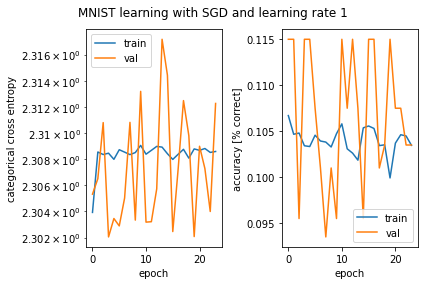

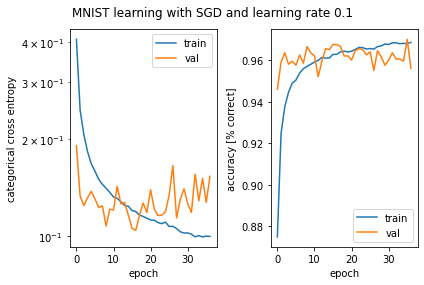

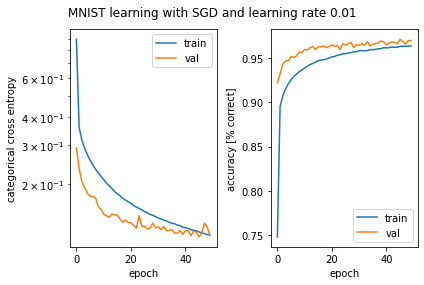

In [499]:
learning_rates = [10**(-e) for e in range(0,4)]

histories_sgd = train_with_various_lr(
    exercise_name='ex_3.2', 
    model=get_model_ex_3_1,
    learning_rates=learning_rates, 
    optimizer=SGD)

#### Exercise 3.3

Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam) (you can use the default learning rate).

In [ ]:
def get_model_ex_3_3(learning_rate):
  """Create a model with 1 hidden layer and 128 units, compiled with Adam optimizer."""
  return get_model(input_dim=input_dim_mnist, layers=1, h=128, optimizer=Adam, lr=learning_rate)

In [ ]:
adam_lr = 0.001
histories_adam = train_with_various_lr(
    exercise_name='ex_3.3', 
    model = get_model_ex_3_3,
    learning_rates=[adam_lr], 
    optimizer=Adam)

#### Exercise 3.4

Plot the learning curves of SGD with a good learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.


In [ ]:
sgd_lr = 0.01
history_good_sgd = histories_sgd[learning_rates.index(sgd_lr)]
comparison_plot_custom(
    history_good_sgd, 
    histories_adam[0], 
    "SGD (LR {0})".format(sgd_lr), 
    "Adam(LR {0})".format(adam_lr), 
    "Optimizer Comparison");

#### Exercise 3.5
Explain the qualitative difference between the loss and accuracy curves with respect to signs of overfitting. Report the best validation accuracy achieved for SGD and Adam. Which one is better and why do you think so?

In [ ]:
print("Best validation accuracies:")
print("- SGD: {0}.".format(round(max(history_good_sgd["val_accuracy"]), 2)))
print("- Adam: {0}.".format(round(max(histories_adam[0]["val_accuracy"]), 2)))

### Exercise 3.6
Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function `plot_some_samples`.

In [ ]:
models = [model_sgd, model_adam]
for model in models:
    y_pred = model.predict_on_batch(x_mnist_val_flat).argmax(axis=1)
    indices = [i for i,v in enumerate(y_pred) if y_pred[i]!=y_mnist_val[i]]
    x_wrongly_predicted = np.asarray([x_mnist_val_flat[i] for i in indices])
    y_wrongly_predicted = np.asarray([y_pred[i] for i in indices])
    y_true_prediction = np.asarray([y_mnist_val[i] for i in indices])
    plot_some_samples_custom(x_wrongly_predicted, y_true_prediction, y_wrongly_predicted, ncols=6, nrows=4);

#### Exercise 3.7

7. Take $ p = 0.2 $ fraction of the data points from the training dataset of MNIST and change their class labels randomly. (You can sample a random integer from 0 to 9 using `np.random.uniform` and `np.floor`). Train with Adam for 50 or 100 epochs. Plot the learning curves. Do you observe overfitting in the validation accuracy? Does it take longer to converge to perfect training accuracy compare to noise-free MNIST? (2 pts)<br/>
**=> The training accuracy is increasing, starting from 80% and reaching around 90% after 100 episodes. The validation accuracy on the other hand is decreasing from 95% to around 80% after 100 episodes. The model is definetly overfitting to the noise in the shifted MNIST dataset. It takes much longer to converge towards the perfect training accuracy on the noisy MNIST dataset.**

In [ ]:
# Train with noisy labels
y_mnist_train_1hot_noisy = noise_labels(y_mnist_train_1hot, p=0.2)
history_adam_noisy = model.compile(optimizer=Adam(learning_rate=adam_lr), loss='categorical_crossentropy', metrics=["accuracy"])
history_adam_noisy = fit_custom('ex_3.7_lr_{0}'.format(adam_lr),
                                model=model,
                                x=x_mnist_tr_flat, 
                                y=y_mnist_train_1hot_noisy, 
                                validation_data=(x_mnist_val_flat, y_mnist_val_1hot),                                  
                                epochs=100, 
                                callbacks=None)

In [ ]:
plot_history_custom(history_adam_noisy, "Noisy MNIST learning with Adam (learning rate {0})".format(adam_lr));

In [ ]:
comparison_plot_custom(histories_adam[0], history_adam_noisy, "LR {0}".format(adam_lr), "Noisy, LR {0}".format(adam_lr), "MNIST Adam with and without noise");

## Exercise 4: Model performance as a function of number of hidden neurons (8 + 2 points)

Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network in Exercise 3, we use the Fashion-MNIST dataset from now on to compare the performances of more complex models. In this exercise, we investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)
2. Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)
3. Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
4. BONUS: Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)
5. Answer to the same questions in 2 for the noisy Fashion-MNIST dataset(s). Comment on the differences between width-performence curves for these two (or three) datasets. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

**Answer to Question 2** (max 2 sentences):
The Universal Approximation Theorem states that a neural network with one hidden layer and unlimited number of hidden neurons can approximate any continuous function for inputs within a specific range and this can also be observed with our example, since the best training accuracy is steadily increasing with the number of hidden neurons.
We can see that our different models are overfitting and the overfitting increases with an increasing number of hidden neurons.

**Answer to Question 5** (max 3 sentences): 
Although the training and validation accuracy of exercise 4.3's models is quite low (since the 50% of the training labels got changed), we can still see that the training accuracy rises significantly with the number of hidden neurons (From 12% to 26%). A neural network with many hidden nodes is still able to learn this highly dataset correctly and achieve a high training accuracy (in accordance with the universal approximation theorem).
In exercise 4.4 we can see that fitting to this slightly noisy dataset still works pretty well, although the model is also overfitting.

#### Useful functions

In [ ]:
def adam_various_neurons(exercise_name, x, y, validation_data, numbers_of_hidden_neurons=[10, 50, 100, 500, 1000], epochs=50, lr=0.001):
  """Train with Adam with various number of hidden neurons."""
  histories=[]
  metrics = {"neurons":[], "min_loss":[], "min_val_loss":[], "max_accuracy":[], "max_val_accuracy":[]}

  for number_of_hidden_neurons in numbers_of_hidden_neurons:
    model = get_model(input_dim=input_dim_fashion, layers=1, h=number_of_hidden_neurons, optimizer=Adam, lr=lr)
    history = fit_custom(exercise_name + "_ANN-with-{0}-hidden-neurons".format(number_of_hidden_neurons),
                         model=model, epochs=epochs,
                         x=x, 
                         y=y, 
                         validation_data=validation_data,                         
                         callbacks=get_callbacks(early_stop = False, save_model=False))
    histories.append(history)
    print(metrics)
    metrics["neurons"].append(number_of_hidden_neurons)
    metrics["min_loss"].append(min(history["loss"]))
    metrics["min_val_loss"].append(min(history["val_loss"]))
    metrics["max_accuracy"].append(max(history["accuracy"]))
    metrics["max_val_accuracy"].append(max(history["val_accuracy"]))

  return histories, metrics

def plot_metrics(metrics):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Validation loss and accuracy / Number of hidden neurons')
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
        fig.set_figheight(6)
        fig.set_figwidth(12)
        ax1.set_xscale('log')
        ax1.set_ylabel("Validation loss")
        ax1.set_xlabel("number of hidden neurons")
        ax1.plot(metrics["neurons"], metrics["min_loss"])
        ax1.plot(metrics["neurons"], metrics["min_val_loss"])
        ax2.set_xscale('log')
        ax2.set_ylabel("Validation accuracy")
        ax2.set_xlabel("number of hidden neurons")
        ax2.plot(metrics["neurons"], metrics["max_accuracy"]);
        ax2.plot(metrics["neurons"], metrics["max_val_accuracy"]);
        finalize_standardplot(fig, ax1, ax2)


#### Exercise 4.1
Fit at least 4 models with different number of hidden neurons (i.e. width) between 10 and 1000 to the Fashion-MNIST dataset. Train with Adam for 50-100 epochs. (2 pts)

In [ ]:
_, metrics = adam_various_neurons(
    exercise_name="ex_4.1", 
    x=x_fashion_tr_flat,
    y=y_mnist_fash_train_1hot, 
    validation_data=(x_fashion_val_flat, y_mnist_fash_val_1hot),
    numbers_of_hidden_neurons=[10, 50, 100, 500, 1000],
    epochs=50,
    lr=adam_lr)

#### Exercise 4.2
Plot the best validation loss and accuracy versus the width. Is the observed trend in accordance with the general approximation theorem? Do you observe an overfitting due to the complexity of the wider networks with more parameters? Report the best validation accuracy. (2 pts)

In [ ]:
plot_metrics(metrics)

#### Exercise 4.3
Choose $ p \geq 0.5 $ fraction of the data points from the training dataset of Fashion-MNIST and change their class labels randomly as in Exercise 3. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)

In [ ]:
numbers_of_hidden_neurons=[10, 50, 100, 150, 200, 250]
histories, metrics = adam_various_neurons(
    exercise_name="ex_4.3", 
    x=x_fashion_tr_flat, 
    y=noise_labels(y_mnist_fash_train_1hot, p=0.5), 
    validation_data=(x_fashion_val_flat, y_mnist_fash_val_1hot), 
    numbers_of_hidden_neurons=numbers_of_hidden_neurons,
    epochs=150,
    lr=adam_lr)

In [ ]:
plot_metrics(metrics)

### Exercise 4.4
Add random Gaussian noise on the input pixels with mean 0 and variance between 0.01-0.5 and use the original labels. For this noisy Fashion-MNIST dataset, fit at least 4 models with different widths between 10 and 250. Train with Adam for at least 150 epochs. Plot the best validation loss and accuracy vs. width. (2 pts)

In [ ]:
_, metrics = adam_various_neurons(
    exercise_name="ex_4.4", 
    x=x_fashion_tr_flat + normal(loc=0,scale=0.05,size=(x_fashion_tr_flat.shape)),
    y=y_mnist_fash_train_1hot, 
    validation_data=(x_fashion_val_flat, y_mnist_fash_val_1hot), 
    numbers_of_hidden_neurons=numbers_of_hidden_neurons,
    epochs=150,
    lr=adam_lr)

In [ ]:
for i in range(len(numbers_of_hidden_neurons)):
  plot_history_custom(histories[i], "{0} hidden neurons".format(numbers_of_hidden_neurons[i]));

In [ ]:
plot_metrics(metrics)

## Exercise 5: Going deeper: tricks and regularization (10 + 2 points)

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. We use Fashion-MNIST dataset in this exercise.  

1. Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs. (2 pts)
2. Plot the learning curves and report the best validation accuracy. Do you observe overfitting? (2 pts)
3. Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?  (2 pts)
4. Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe? (2 pts)
5. BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts)

Note that one needs to cross-validate to find the right regularization parameter for the model you chose and for the dataset at hand. However we do not enforce this hyperparameter search as it takes long computation times but it is a good practice if you try it here. 

6. Compare the validation accuracies resulting from your attempts to reduce overfitting. Did you improve the validation accuracy? If not, comment on the possible sources of failure. (2 pts)

**Answer to Question 2** (max 1 sentence):<br/>
Overfitting can be observed in the training process since the loss is decreasing but the validation loss is increasing and the validation accuracy levels out after 25 epochs although the training accuracy still keeps increasing.

Best validation accuracy: 0.85.

**Answer to Question 3** (max 2 sentences): 
With lambda equals 1 the best validation accuracy is 0, and .9 with lambda equals 0.001 the best validation accuracy is 0.89, almost the same. But with the lambda equals 1, the training converges faster (only after 5 epochs), then the learning has no more effect, and it slightly overfit.

**Answer to Question 4** (max 2 sentences): 
With dropout equals 0.5, the best validation accuracy is 0.64 and with dropout equals 0.05, the best validation accuracy is 0.86. With the dropout at 0.5 the training converges faster (only after 5 epochs), then the learning has no more effect, and then it doesn't learn anymore.

**Answer to Question 5 (BONUS)** (max 2 sentences):
With data augmentation, the best validation accuracy is 0.88, so similar to previous ones. We notice that the learning is longer.

**Answer to Question 6** (max 2 sentences): 
Our attempts where succeful to reduce overfitting, but not to improve the validation accuracy.


### Solution

#### Useful functions

In [ ]:
def unison_shuffled(a, b):
    """Shuffle both inputs along first axis in the same way."""
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def add_depth_to_images(images):
  """set depth at 1 for all images of the dataset."""
  new_shape = (-1, images.shape[1], images.shape[2], 1)
  return np.reshape(images, new_shape)

def data_augmentation(images, labels, batch_size):

  data_gen_args = dict(featurewise_center=False,
                    featurewise_std_normalization=False,
                    rotation_range=15,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    horizontal_flip=True)
  
  # set depth at 1 
  images = add_depth_to_images(images)

  image_datagen = ImageDataGenerator(**data_gen_args)
  image_datagen.fit(images, augment=True)
  image_generator = image_datagen.flow(images, labels,
    batch_size=batch_size)

  return image_generator

#### Exercise 5.1
Choose a width $ h $ between 50-200 and use at least two hidden layers with $ h $ hidden neurons (each) and train the network for at least 150 epochs.
#### Exercise 5.2
Plot the learning curves and report the best validation accuracy. Do you observe overfitting?


In [ ]:
h = 128
history = fit_custom_(
    exercise_name='ex_5.2_h_{0}'.format(h),
    model=get_model(input_dim=input_dim_mnist, layers=2, h=h, optimizer=SGD, lr=0.01), 
    x_train=x_fashion_tr_flat, 
    y_train=y_mnist_fash_train_1hot, 
    x_val=x_fashion_val_flat,
    y_val=y_mnist_fash_val_1hot, 
    epochs=150)

In [ ]:
plot_history_custom(history, "Fashion MNIST learning with two hidden layers (h = {0})".format(h));

In [ ]:
print("For Fashion MNIST learning with two hidden layers (h = {0}), the best validation accuracy is {0}.".format(round(max(history["val_accuracy"]), 2)))

#### Exercise 5.3
Keep the network at the same size. Use a very large l2 regularization $\lambda$ (for ex. $\lambda=1$) and a small one (for ex. $\lambda=0.001$) on kernel weights and report the validation accuracies. What do you observe?

In [ ]:
l2 = 1
history = fit_custom_(exercise_name='ex_5.3.1_h_{0}_l2_{1}'.format(h, l2),
                     model=get_model(input_dim=input_dim_mnist, layers=2, h=h, optimizer=SGD, lr=0.01, l2=l2), 
                     x_train=x_fashion_tr_flat,
                     y_train=y_mnist_fash_train_1hot, 
                     x_val=x_fashion_val_flat,
                     y_val=y_mnist_fash_val_1hot,                      
                     epochs=150)

In [ ]:
plot_history_custom(history, "Fashion MNIST learning with two hidden layers (h = {0}, l2 = {1})".format(h, l2));

In [ ]:
print("With l2 regularization (lambda = {0}), the best validation accuracy is {01}.".format(l2, round(max(history["val_accuracy"]), 2)))

In [ ]:
l2 = 0.001
history = fit_custom_(exercise_name='ex_5.3.2_h_{0}_l2_{1}'.format(h, l2),
                     model=get_model(input_dim=input_dim_mnist, layers=2, h=h, optimizer=SGD, lr=0.01, l2=l2),
                     x_train=x_fashion_tr_flat, 
                     y_train=y_mnist_fash_train_1hot, 
                     x_val=x_fashion_val_flat,
                     y_val=y_mnist_fash_val_1hot,                      
                     epochs=150)

In [ ]:
plot_history_custom(history, "Fashion MNIST learning with two hidden layers (h = {0}, l2 = {1})".format(h, l2));

In [ ]:
print("With l2 regularization (lambda = {0}), the best validation accuracy is {01}.".format(l2, round(max(history["val_accuracy"]), 2)))

#### Exercise 5.4
Turn off the $ \ell_2 $ regularization and use a large dropout rate (for ex. 0.5) and a small one (for ex. 0.05) at all hidden layers and report the validation accuracies. What do you observe?

In [ ]:
dropout = 0.5
history = fit_custom_(exercise_name='ex_5.4_h_{0}_dropout_{1}'.format(h, dropout),
                     x_train=x_fashion_tr_flat, 
                     y_train=y_mnist_fash_train_1hot, 
                     x_val=x_fashion_val_flat, 
                     y_val=y_mnist_fash_val_1hot, 
                     model=get_model(input_dim=input_dim_mnist, layers=2, h=h, optimizer=SGD, lr=0.01, dropout=dropout),
                     epochs=150,)

Begin to train the model ex_5.4_h_128_dropout_0.5.


In [ ]:
plot_history_custom(history, "Fashion MNIST learning with two hidden layers (h = {0}, dropout = {1})".format(h, dropout));

In [ ]:
print("With dropout = {0}, the best validation accuracy is {1}.".format(dropout, round(max(history["val_accuracy"]), 2)))

In [ ]:
dropout = 0.05
history = fit_custom_(exercise_name='ex_5.4_h_{0}_dropout_{1}'.format(h, dropout),
                     x_train=x_fashion_tr_flat, 
                     y_train=y_mnist_fash_train_1hot, 
                     x_val=x_fashion_val_flat, 
                     y_val=y_mnist_fash_val_1hot, 
                     model=get_model(input_dim=input_dim_mnist, layers=2, h=h, optimizer=SGD, lr=0.01, dropout=dropout),
                     epochs=150)

In [ ]:
plot_history_custom(history, "F-MNIST learning with 2 hidden layers (h = {0}) and dropout = {1}".format(h, dropout));

In [ ]:
print("With dropout = {0}, the best validation accuracy is {1}.".format(dropout, round(max(history["val_accuracy"]), 2)))

#### Exercise 5.5

BONUS: Try built-in data augmentation methods as a way to regularize: this may include horizontal flipping of the images or small rotations. You can use built-in methods in Keras. Report the augmentation method you used and the best validation accuracy. (2 pts) 

In [ ]:
# Use a small subset of the dataset to visualize the effect of data augmentation
ncols=4
nrows=2
total = ncols * nrows
x_mnist_fash_train_small = x_mnist_fash_train[0:total]
y_mnist_fash_train_1hot_small = y_mnist_fash_train_1hot[0:total]

image_generator_small = data_augmentation(x_mnist_fash_train_small, y_mnist_fash_train_1hot_small, batch_size=total)
augmented_samples_small = next(image_generator_small)

In [ ]:
print("Initial images:")
plot_some_samples(x_mnist_fash_train_small, y_mnist_fash_train_1hot_small, ncols=ncols, nrows=nrows);

In [ ]:
print("Modified images:")
plot_some_samples(augmented_samples_small[0], augmented_samples_small[1], ncols=ncols, nrows=nrows);

In [ ]:
# Generate new data
image_generator = data_augmentation(
    x_mnist_fash_train, 
    y_mnist_fash_train_1hot, 
    batch_size=x_mnist_fash_train.shape[0])

augmented_samples = next(image_generator)
print("Generated dataset shape x: {0} / y : {1}".format(augmented_samples[0].shape, augmented_samples[1].shape))

# Flatten images
x_fash_augmented = augmented_samples[0].reshape(x_mnist_fash_train.shape[0], x_mnist_fash_train.shape[1]*x_mnist_fash_train.shape[2])

# Normalize
x_fash_augmented = x_fash_augmented / max_grey_value

y_fash_1hot_augmented = augmented_samples[1]

In [ ]:
# Add to initial dataset
x_fash_augmented = np.concatenate([x_fashion_tr_flat, x_fash_augmented])
y_fash_1hot_augmented  = np.concatenate([y_mnist_fash_train_1hot, y_fash_1hot_augmented])

In [ ]:
# Schuffle in the same way
x_fash_augmented, y_fash_1hot_augmented = unison_shuffled(x_fash_augmented, y_fash_1hot_augmented)

print("Augmented x training data from {0} to {1}".format(x_fashion_tr_flat.shape, x_fash_augmented.shape))
print("Augmented y training data from {0} to {1}".format(y_mnist_fash_train_1hot.shape, y_fash_1hot_augmented.shape))

In [ ]:
history = fit_custom(
    exercise_name = "ex_5.5",
    x=x_fash_augmented,
    y=y_fash_1hot_augmented,
    validation_data=(x_fashion_val_flat, y_mnist_fash_val_1hot), 
    model = get_model(input_dim=input_dim_fashion, layers=2, h=h, optimizer=SGD, lr=0.01),
    epochs=200, 
    callbacks=get_callbacks(early_stop=True))

In [ ]:
plot_history_custom(history=history, title='F-MNIST with data augmentation.');

In [ ]:
print("With data augmentation, the best validation accuracy is {0}.".format(round(max(history["val_accuracy"]), 2)))

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

Convolutional neural networks have an inductive bias that is well adapted to image classification. 

1. Design a convolutional neural network and train it without using explicit regularizers. (2 pts)
2. Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases. (4 pts)
3. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot. (2pts)
4. How does the CNN performance compare to the so far best performing (deep) neural network model? (2 pts)

*Hint:* You may get valuable inspiration from the keras [examples](https://keras.io/examples/), [for example](https://keras.io/examples/vision/mnist_convnet/).

**Answer to Question 4**: 

### Solution
The best performing deep neural network achieves a validation accuracy of around 89%.
However they tend to overfit to the training data.
Especially the tuned CNN achieves much higher validation and test accuracy (~93%) with less overfitting.

#### Useful functions


In [ ]:
def build_cnn(l2_lambda_value=0, is_dropout=False, is_batch_normalization=False):
    """Builds the base Keras model, without any regularization."""
    # Clear the session to remove all the nodes left over from previous models, free memory and preventing slowdown.
    K.clear_session()
    
    kernel_regularizer = None if not l2_lambda_value else regularizers.l2(l2_lambda_value)
    
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', 
                                  input_shape=(28, 28, 1), kernel_regularizer=kernel_regularizer))
    
    if is_batch_normalization:
        model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', 
                                  kernel_regularizer=kernel_regularizer))
    if is_batch_normalization:
        model.add(keras.layers.BatchNormalization())
        
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    if is_dropout:
        model.add(keras.layers.Dropout(0.125))
    
    model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', 
                                  padding='same', kernel_regularizer=kernel_regularizer))
    if is_batch_normalization:
        model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', 
                                  kernel_regularizer=kernel_regularizer))
    if is_batch_normalization:
        model.add(keras.layers.BatchNormalization())
   
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
    if is_dropout:
        model.add(keras.layers.Dropout(0.25))
        
    model.add(keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', 
                                  padding='same', kernel_regularizer=kernel_regularizer))
    if is_batch_normalization:
        model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', 
                                  kernel_regularizer=kernel_regularizer))
    
    if is_batch_normalization:
        model.add(keras.layers.BatchNormalization())  
    
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2))) 
    if is_dropout:
        model.add(keras.layers.Dropout(0.5))
    
    model.add(keras.layers.Flatten()) 
    
    model.add(keras.layers.Dense(1024, activation='relu', kernel_regularizer=kernel_regularizer))
    if is_dropout:
        model.add(keras.layers.Dropout(0.5))

    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=kernel_regularizer))
    if is_dropout:
        model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    adam = Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
    

#### Exercise 6.1.
Design a convolutional neural network and train it without using explicit regularizers.

In [ ]:
# Images must be in 4 dimensions, we must reshape
x_mnist_fash_train_with_depth = add_depth_to_images(x_mnist_fash_train)
x_mnist_fash_val_with_depth = add_depth_to_images(x_mnist_fash_val)
#x_mnist_fash_val_with_depth = add_depth_to_images(x_mnist_fash_val)

print("Reshaped train data from {0} to {1}".format(x_mnist_fash_train.shape, x_mnist_fash_train_with_depth.shape))
print("Reshaped validation data from {0} to {1}".format(x_mnist_fash_val.shape, x_mnist_fash_val_with_depth.shape))

In [ ]:
model = build_cnn(l2_lambda_value=0,
                  is_dropout=False,
                  is_batch_normalization=False)
model.summary()

In [ ]:
history_no_regularization = fit_custom_(
    exercise_name="ex_6.1", 
    model=model, 
    x_train=x_mnist_fash_train_with_depth, 
    y_train=y_mnist_fash_train_1hot, 
    x_val=x_mnist_fash_val_with_depth, 
    y_val=y_mnist_fash_val_1hot,  
    epochs=50,
    callbacks=None, 
    verbose=0)

In [ ]:
plot_history_custom(history_no_regularization, "Training history of naive CNN");

In [ ]:
print("For the CNN without regularization, the best validation accuracy is {0}.".format(round(max(history_no_regularization["val_accuracy"]), 2)))

In [ ]:
"""  # evaluate metrics
  print("\nEvaluating...", flush=True)
  print('Training data:', flush=True)
  loss, acc = model.evaluate(x_train, y_train, verbose=1)
  print("  Training : loss %.3f - acc %.3f" % (loss, acc))
  print('Cross-validation data:', flush=True)
  loss, acc = model.evaluate(x_val, y_val, verbose=1)
  print("  Cross-val: loss %.3f - acc %.3f" % (loss, acc))"""

"""
best_naive_model = load_model(get_path_model(name), compile=True)
val_err_naive, val_acc_naive = best_naive_model.evaluate(x_mnist_fash_val_re, y_mnist_fash_val_1hot, verbose=0)
test_err_naive, test_acc_naive = best_naive_model.evaluate(x_mnist_fash_val_re, y_mnist_fash_val_1hot, verbose=0)
print("{name}: val_err: {err}, val_acc: {acc}".format(name=name, err=val_err_naive, acc=val_acc_naive))
print("{name}: test_err: {err}, test_acc: {acc}".format(name=name, err=test_err_naive, acc=test_acc_naive))
"""

#### Exercise 6.2.
Try to improve the best validation scores of the model by experiment with batch_normalization layers, dropout layers and l2-regularization on weights (kernels) and biases

In [ ]:
model = build_cnn(l2_lambda_value=0.01,
                  is_dropout=True,
                  is_batch_normalization=True)
model.summary()

In [ ]:
history_tuned = fit_custom_(
    exercise_name="ex_6.2", 
    model=model, 
    x_train=x_mnist_fash_train_with_depth, 
    y_train=y_mnist_fash_train_1hot, 
    x_val=x_mnist_fash_val_with_depth, 
    y_val=y_mnist_fash_val_1hot,  
    epochs=50,
    callbacks=None, 
    verbose=0)

In [ ]:
plot_history_custom(history, "Training history of tuned CNN");

In [ ]:
print("For the tuned CNN, the best validation accuracy is {0}.".format(round(max(history["val_accuracy"]), 2)))

In [ ]:
"""best_tuned_model = load_model(get_path_model(name), compile=True)
val_err_tuned, val_acc_tuned = best_tuned_model.evaluate(x_mnist_fash_val_re, y_mnist_fash_val_1hot, verbose=0)
test_err_tuned, test_acc_tuned = best_tuned_model.evaluate(x_mnist_fash_val_re, y_mnist_fash_val_1hot, verbose=0)
print("{name}: val_err: {err}, val_acc: {acc}".format(name=name, err=val_err_tuned, acc=val_acc_tuned))
print("{name}: test_err: {err}, test_acc: {acc}".format(name=name, err=test_err_tuned, acc=test_acc_tuned))"""

#### Exercise 6.3.
After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized) together in a comparison plot.

In [ ]:
comparison_plot_custom(history_no_regularization, history_tuned, "Naive", "Tuned", "Model Comparison");